In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib
import time
import scipy as sp
import pre_processing_3d as pre_processing
import pandas as pd
from mpl_toolkits import mplot3d
from scipy.spatial import distance
import math
import time 

# import pre_processing_acc #problèmes de compatbilité ici

verbose = True

# ----------------
#  BASE MODEL
# ----------------

def basemodel(N_sat, N_cities, N_grid, population, coverage):
    """
    N_sat:      number of satellites to place
    N_cities:   number of cities
    N_grid:     number of grid points (possible satellite positions)
    population: numpy array of size N_cities containing the population of each city
    coverage:   binary numpy array of size N_cities x N_grid containing the coverage of each city by each satellite:
                coverage[i][j] == True if city i is covered by satellite j, 0 otherwise
    """
    
    # Variables
    y = cp.Variable(N_cities, name="y", boolean=True) # y[i] = 1 si ville i est couverte par un satellite, 0 sinon
    x = cp.Variable(N_grid, name="x", boolean=True)   # x[j] = 1 si satellite placé à la position j, 0 sinon

    # Objectif
    cout = cp.multiply(population, y) # population couverte (multiplication elementwise)
    objectif = cp.Maximize(cp.sum(cout)) # maximise la norme 1 (somme) des populations couvertes

    # Contraintes
    contraintes = []

    # N satellites
    contraintes.append(cp.sum(x) <= N_sat)
    
    # Couverture
    for i in range(N_cities):
        vec_couverture = np.zeros(N_grid, dtype=bool)
        vec_couverture[coverage[i]] = True
        
        contraintes.append(y[i] <= cp.sum(cp.multiply(x, vec_couverture)))

    # Debug: voir si les contraintes respectent les DCP rules
    if verbose:
        for i in range(len(contraintes)):
            if not (contraintes[i].is_dcp()):
                print("Contrainte", i, "ne respecte pas DCP rules")

    # Solveur problème
    return cp.Problem(objectif, contraintes)

# -------------------


def to_xyz(cities):
    """
    In:
    - cities : [lat, lon]

    Out:
    - cities_xyz : [x, y, z]
    """
    N_cities = len(cities)
    cities_xyz = np.zeros((N_cities,3))
    for i, city in enumerate(cities):
        lat = city[0]
        lon = city[1]
        x = math.cos(lat) * math.cos(lon)
        y = math.cos(lat) * math.sin(lon)
        z = math.sin(lat)
        cities_xyz[i,:] = [x, y, z]
    return cities_xyz


In [2]:


filename = "../geonames_smol.csv"   # <-- Mettre ici les noms des fichiers csv à tester
cities = pre_processing.get_cities_old(filename)


N_sat = 6
radius = 0.4
grid_size_X = 30
grid_size_Y = 30



j = 0

# Preprocessing
startpre = time.time()
grid = pre_processing.calc_grid_3d(grid_size_X, grid_size_Y, h=1.2)


N_cities = len(cities)
N_grid = len(grid) * len(grid[0])

population = [cities[i][2] for i in range(len(cities))]
cities_xyz = to_xyz(cities)

print(cities_xyz)


covered_adj = pre_processing.calc_adj(cities=cities, grid=grid, radius=radius)  
endpre = time.time()

print("Preprocessing time:", endpre - startpre)

[[ 0.14072311  0.38435311  0.91239777]
 [ 0.25385376  0.96620497 -0.04479091]
 [ 0.14774627  0.30757056 -0.93998478]
 ...
 [ 0.52304218 -0.158957    0.8373527 ]
 [-0.78912539  0.16765929 -0.59090733]
 [ 0.36795416  0.69620785 -0.61636383]]
Preprocessing time: 22.469220399856567


In [3]:
# EXPERIENCE: Modifier N_sat

save_x = []
save_y = []
save_sol = []
save_times = []

all_sats = [1,3,5,10]

for j, N_sat in enumerate(all_sats):
    startsolve = time.time()
    problem = basemodel(N_sat, N_cities, N_grid, population, covered_adj)
    problem.solve(verbose=False, warm_start=True)
    endsolve = time.time()

    vars = problem.variables()

    # Save variables
    for k in range(2):
        if vars[k].name() == "x":
            save_x.append(vars[k].value)
        elif vars[k].name() == "y":
            save_y.append(vars[k].value)

    save_sol.append(problem.value / np.sum(population) * 100)
    save_times.append(endsolve - startsolve)

    if verbose:
        print("\n=========== PROBLEME", j+1, "===========")
        #print("Population :", population)
        #print("Couverture :", coverage)
        print("Nombre de satellites : %d" % N_sat)
        print("Statut : %s" % problem.status)
        print("Population couverte : %d (%f %%)" % (problem.value, problem.value / np.sum(population) * 100))
        print("Temps de solve : %f sec" % (endsolve - startsolve))
        #print("Variables x :", save_x[-1])



=========== PROBLEME 1 ===========
Nombre de satellites : 1
Statut : optimal
Population couverte : 0 (0.000000 %)
Temps de solve : 4.429496 sec

=========== PROBLEME 2 ===========
Nombre de satellites : 3
Statut : optimal
Population couverte : 0 (0.000000 %)
Temps de solve : 3.202388 sec

=========== PROBLEME 3 ===========
Nombre de satellites : 5
Statut : optimal
Population couverte : 0 (0.000000 %)
Temps de solve : 3.983851 sec

=========== PROBLEME 4 ===========
Nombre de satellites : 10
Statut : optimal
Population couverte : 0 (0.000000 %)
Temps de solve : 3.630599 sec


In [7]:
print("Positions satellites:", np.where(save_x[0] == 1)[0])

Positions satellites: []


In [4]:
for N_sat, sat_positions, sol in zip(all_sats,save_x, save_sol):
    for y in range(len(grid)):
        for x in range(len(grid[0])):
            plt.plot(grid[y][x][0], grid[y][x][1], "o", color="black", alpha=0.3)


    for i in range(len(cities)):
        plt.plot(cities[i][0], cities[i][1], "o", color="blue", alpha=0.3)


    #sat_positions = np.array(save_x[-1])
    indices_sat_positions = np.where(sat_positions > 1-1e-3)[0]
    #print("Positions satellites (id grid) :", indices_sat_positions)
    for i in indices_sat_positions:
        y,x = pre_processing.index_to_grid(i, len(grid), len(grid[0]))
        plt.plot(grid[y][x][0], grid[y][x][1], "*", color="red", markersize=15)
        circle = plt.Circle((grid[y][x][0], grid[y][x][1]), radius, color='red', fill=False, linestyle="--", zorder=2, linewidth=2)
        plt.gca().add_patch(circle)

    plt.legend()
    # Add the radius and number of satellites to the figure
    plt.title("N_sat: %d, Rayon: %.2f km, Couverture: %.4f %%" % (N_sat, 40, sol))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()


IndexError: invalid index to scalar variable.

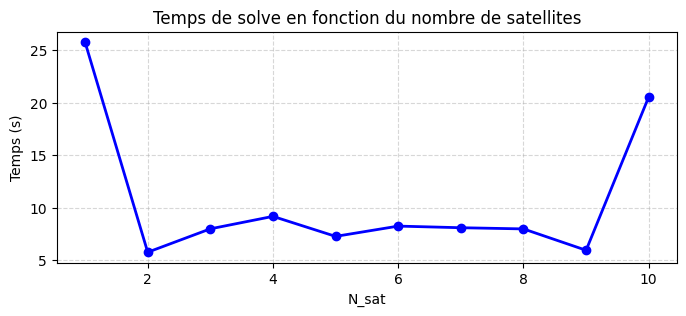

In [ ]:
plt.figure(figsize=(8, 3))  # Set the figsize to make the plot wider
plt.plot(all_sats, save_times, color='blue', marker='o', linestyle='-', linewidth=2)
plt.xlabel('N_sat')
plt.ylabel('Temps (s)')
plt.title('Temps de solve en fonction du nombre de satellites')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
